In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128
# Plot size to 14" x 7"
mpl.rc('figure', figsize = (14, 7))
# Font size to 14
mpl.rc('font', size = 14)
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False)
# Remove grid lines
mpl.rc('axes', grid = False)
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')

In [2]:
df = pd.read_csv("2007-2017.csv")
df.shape

(341170, 9)

In [3]:
from sklearn.utils import resample

df_majority = df[df['enquiry status'] == 'Rejected']
df_minority = df[df['enquiry status'] == 'Accepted']


# Upsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=84136,    # to match majority class
                                 random_state=123) # reproducible results



# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled['enquiry status'].value_counts()

Rejected    84136
Accepted    84136
Name: enquiry status, dtype: int64

In [4]:
# # Separate majority and minority classes
# df_majority = df[df['enquiry status'] == 'Rejected']
# df_minority = df[df['enquiry status'] == 'Accepted']
 
# # Upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=218370,    # to match majority class
#                                  random_state=123) # reproducible results
 
# # Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# # Display new class counts
# df_upsampled['enquiry status'].value_counts()

In [5]:
df = df_downsampled

In [6]:
target = 'enquiry status';

X = df[df.keys()]
X = df.loc[:,df.columns != target]
y = df[target]

In [7]:
category_column = X.select_dtypes(include='object')

In [8]:
from sklearn import preprocessing

transform_dict = {}
for col in category_column.columns:
    le = preprocessing.LabelEncoder()
    X[col] = le.fit_transform(X[col])
    transform_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [9]:
from sklearn.preprocessing import StandardScaler

feat_labels = X.columns[0:]
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
# from sklearn.model_selection import GridSearchCV
# from sklearn import linear_model
# from sklearn.ensemble import RandomForestClassifier

# # Create logistic regression
# randomForest = RandomForestClassifier()

# # Create range of candidate penalty hyperparameter values
# n_estimators = [100, 500, 1000]
# max_features = [3, 5, 8]

# # Create dictionary hyperparameter candidates
# hyperparameters = dict(n_estimators=n_estimators, max_features=max_features)

# # Create grid search
# gridsearch = GridSearchCV(randomForest, hyperparameters, cv=5, verbose=0 , n_jobs=-1)

# # Fit grid search
# best_model = gridsearch.fit(X, y)

In [11]:
# # View best hyperparameters
# print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
# print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])

In [12]:
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                     test_size=0.4,
                     random_state=0,
                     stratify=y)

In [13]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(n_estimators=500, n_jobs=-1)
randomForest.fit(X_train, y_train)
rf_label = randomForest.predict(X_test)
print('Test Accuracy: %.3f' % randomForest.score(X_test, y_test))

Test Accuracy: 0.739


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation

scores = cross_validation.cross_val_score(randomForest, X, y, cv=5)
print("Random forest cross_validation: {:.2f}".format(np.mean(scores, axis=0)))

print("Random forest")
print(classification_report(y_test, rf_label))

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Random forest cross_validation: 0.66
Random forest
             precision    recall  f1-score   support

          0       0.71      0.80      0.75     33655
          1       0.77      0.68      0.72     33654

avg / total       0.74      0.74      0.74     67309



In [15]:
prob_y_2 = randomForest.predict_proba(X)
prob_y_2 = [p[1] for p in prob_y_2]
print( roc_auc_score(y, prob_y_2) )

0.965214336697


In [16]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=randomForest,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=-1,verbose=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)



[learning_curve] Training set sizes: [ 9086 18173 27259 36346 45432 54519 63605 72692 81778 90865]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.3min finished


train_mean [ 0.99996698  0.99984593  0.99981657  0.99977164  0.99973147  0.99968451
  0.99966355  0.99961756  0.99950353  0.99946294]
train_std [  9.90534889e-05   5.39149231e-05   2.84161807e-05   1.76171360e-05
   1.32065504e-05   1.59903848e-05   1.44094826e-05   1.92593408e-05
   4.13596188e-05   3.10498783e-05]
train_mean [ 0.99996698  0.99984593  0.99981657  0.99977164  0.99973147  0.99968451
  0.99966355  0.99961756  0.99950353  0.99946294]
test_std [ 0.00446161  0.00469818  0.00422975  0.0042989   0.00436163  0.00412826
  0.00518726  0.00404882  0.00502627  0.00453966]


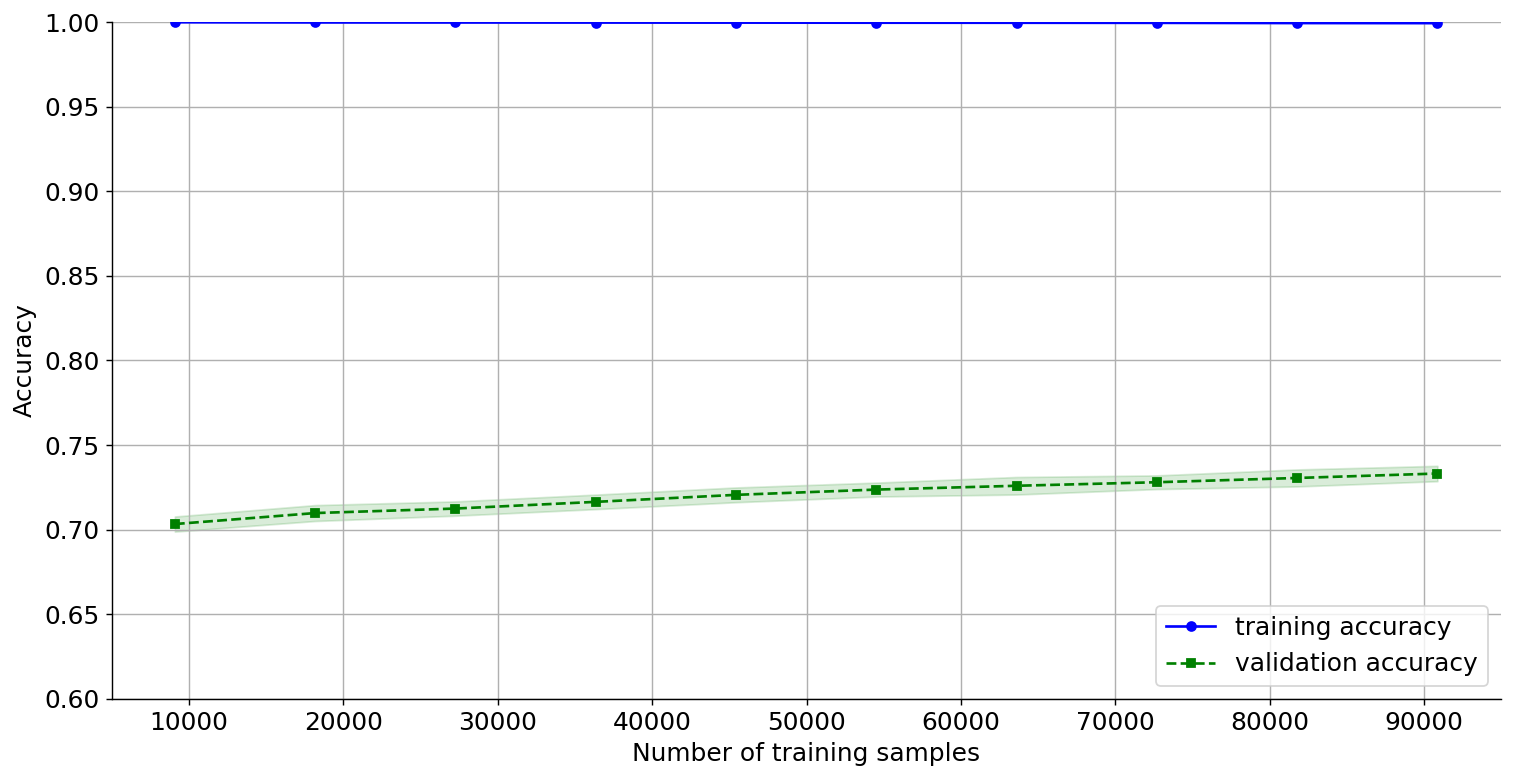

In [17]:
print("train_mean",train_mean)
print("train_std",train_std)
print("train_mean",train_mean)
print("test_std",test_std)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.show()

In [18]:
# feat_labels = X.columns[0:]
importances = randomForest.feature_importances_

# reverse the list
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importances[indices[f]]))

 1) loan amount                    0.358336
 2) day                            0.150458
 3) hour                           0.134279
 4) classification                 0.116534
 5) month                          0.099036
 6) weekday                        0.064033
 7) loan reason                    0.054580
 8) property use                   0.022744


In [19]:
from sklearn.externals import joblib
encoder = joblib.load('app/models/encoder.pkl')

In [20]:
import json
my_json_string = json.dumps({
#     'marketing_code':'P0001',
    "classification": "Direct",
    "enquired":"29/1/15 12:10",
    "loan amount": "1184000",
    "property_use": "Residence",
    "loan_reason": "Refinance"
})

In [21]:
data = json.loads(my_json_string)
data = pd.DataFrame(data,index=[0])

In [22]:
def transform_cols(df):
    df.columns = map(str.lower, df.columns)
    df.columns = df.columns.str.replace('_', ' ')
    return df

In [23]:
transform_cols(data)

,classification,enquired,loan amount,loan reason,property use
0,Direct,29/1/15 12:10,1184000,Refinance,Residence


In [24]:
data.dtypes

classification    object
enquired          object
loan amount       object
loan reason       object
property use      object
dtype: object

In [25]:
def transform(df): 
    if 'loan amount' in df.columns: 
        df['loan amount'] = df['loan amount'].astype('float')
        
    if 'enquired' in df.columns: 
        df['enquired'] = pd.DatetimeIndex(df['enquired'])
        df['month'] = df['enquired'].dt.month
        df['day'] = df['enquired'].dt.day
        df['hour'] = df['enquired'].dt.hour
        df['weekday'] = df['enquired'].dt.dayofweek
    
    if 'post code' in df.columns: 
        df['post code'] = df['post code'].astype('int')
    
    if 'enquired'in df.columns:
        df.drop(['enquired'], axis = 1, inplace = True)

    return df.replace(encoder)

In [26]:
data = transform(data)
data.dtypes

classification      int64
loan amount       float64
loan reason         int64
property use        int64
month               int64
day                 int64
hour                int64
weekday             int64
dtype: object

In [27]:
data

,classification,loan amount,loan reason,property use,month,day,hour,weekday
0,7,1184000.0,4,2,1,29,12,3


In [28]:
randomForest.predict(data)

array([0])

In [29]:
print("posibility is: {}".format(np.max(randomForest.predict_proba(data))))

posibility is: 0.63


In [30]:
df = pd.read_csv("2009-2017_origin.csv")

In [31]:
df['classification'].value_counts()

Domain                         47775
Google AdWords                 26835
Direct                         25516
Coregistration                 21864
REA                            19767
Alternative Media              19131
Affiliate                      17338
None                           14050
Omnilead                       12845
Home Sales                      8089
All Homes                       7678
Partners                        5800
First Home Buyers               5516
Domain Campaigns                5171
Phone                           4731
Email eChoice Database          4357
Finder                          3971
Domain Internal CBA Program     3620
Domain Campaigns CPA            1975
Domain Competitions             1791
External Email                  1275
Folio                           1173
Dynamic Home Loans              1093
Retention                        901
Refinancing AdWords              893
Portals                          775
Portal Campaigns                 735
M

In [32]:
test = df[df['enquiry status'] == 'Accepted']
# test = test[test['classification'] == 'Domain']
test = test.loc[:,test.columns != 'enquiry status']

In [33]:
test = transform(test)

In [34]:
# test

In [35]:
prediction = randomForest.predict(test)

In [36]:
proba = []
result = randomForest.predict_proba(test)
for row in range(len(result)):
    proba.append(np.max(result[row]))

In [37]:
test["prediction"] = prediction
test["proba"] = proba

In [38]:
test.sort_values(by=['proba'],ascending=False)

,classification,loan amount,loan reason,property use,month,day,hour,weekday,prediction,proba
94476,0,100000.0,4,0,5,1,0,4,0,0.804
92546,22,1000000.0,0,0,12,1,8,1,1,0.772
9309,6,331000.0,0,2,10,1,7,1,1,0.772
9314,7,315000.0,0,0,10,1,9,1,1,0.772
9315,6,558000.0,0,2,10,1,10,1,1,0.772
264172,31,300000.0,0,2,12,1,15,1,1,0.772
102003,22,120000.0,0,2,4,1,20,1,1,0.772
9333,22,668000.0,0,0,10,1,12,1,1,0.772
9335,22,330000.0,0,2,10,1,13,1,1,0.772
213927,19,270000.0,0,2,3,1,8,1,1,0.772


In [39]:
test[test['proba'] < 0.56].count()

classification    22589
loan amount       22589
loan reason       22589
property use      22589
month             22589
day               22589
hour              22589
weekday           22589
prediction        22589
proba             22589
dtype: int64

In [40]:
test[test["prediction"] == 1].count()

classification    21479
loan amount       21479
loan reason       21479
property use      21479
month             21479
day               21479
hour              21479
weekday           21479
prediction        21479
proba             21479
dtype: int64

In [41]:
test[test["prediction"] == 0].count()

classification    28861
loan amount       28861
loan reason       28861
property use      28861
month             28861
day               28861
hour              28861
weekday           28861
prediction        28861
proba             28861
dtype: int64

In [42]:
X_train.shape

(100963, 8)